# Implementing RoBERTa with fastai and HuggingFace 🤗Transformers

## Acknowledgements:

This notebook is based off of this great tutorial kernel and accompanying [article](https://medium.com/p/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2?source=email-29c8f5cf1dc4--writer.postDistributed&sk=119c3e5d748b2827af3ea863faae6376): <br>
https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta

Here, I've just implemented roBERTa, but go check out the original kernel to see how the same procedure could be used for BERT, RoBERTa, XLNet, XLM, and DistilBERT). I'd love if you upvote my kernel, but make sure to give the original votes, too. 

## Google Quest Q&A Overview

This challenge is about questions and answers. 

In [question answering (QA)](https://en.wikipedia.org/wiki/Question_answering) systems are built that automatically answer questions posed by humans in a natural language. These computer systems excel at answering questions with single, verifiable answers. In contrast, humans are better at addressing subjective questions that require a deeper, multidimensional understanding of context.  

For the [Google QUEST Q&A Labeling competition](https://www.kaggle.com/c/google-quest-challenge/overview), we're tasked with predicting different subjective aspects of question-answering. The data for this competition includes questions and answers, and the task is to predict target values of 30 labels for each question-answer pair.Target labels with the prefix question_ relate to the question_title and/or question_body features in the data, and target labels with the prefix answer_ relate to the answer feature.

This is not a binary prediction challenge. Target labels are aggregated from multiple raters, and can have continuous values in the range [0,1]. Submissions are evaluated with the mean [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

## Transfer learning approach

The first **transfer learning** method applied to Natural Language Processing (NLP) was [Universal Language Model Fine-tuning for Text Classification](https://medium.com/r/?url=https%3A%2F%2Farxiv.org%2Fpdf%2F1801.06146.pdf).(ULMFiT) method. This method involves starting with a pre-trained language model (LM), for example, trained on the Wikitext 103 dataset, and then fine tuning the language model on a new dataset. The fine tuned language model can then be used ina classification task for the new dataset. A demonstration is in the [fast.ai course](https://course.fast.ai/videos/?lesson=4), incorporating other techniques like discriminate learning rates, gradual model unfreezing, and slanted triangular learning rates.

Recently, a new architecture called the **Transformer** (cf. [Attention is all you need](https://arxiv.org/abs/1706.03762)) has been shown to be powerful. Google (BERT, Transformer-XL, XLNet), Facebook (RoBERTa, XLM) or even OpenAI (GPT, GPT-2) have pre-trained their own models (that use architectures based on the Transformer) on very large corpora. 

These transformers are availiable through the [HuggingFace](https://huggingface.co/) 🤗 [transformers library](https://github.com/huggingface/transformers). Formerly knew as ``pytorch-transformers`` or ``pytorch-pretrained-bert``, this library has both pre-trained NLP models and additional utilities like tokenizers, optimizers and schedulers. 

This kernel uses the ``transformers`` library within the ``fastai`` framework. Specifically, I am using the [RoBERTa model](https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8). I've broken the process down into different parts:
1. Specifying Data Preprocessing
1. Loading and Processing Data
1. Creating the Model
    - New! including the challenge metric
1. Training the Model
1. Predictions and Submission

# Set Up and Data Loading

This kernel uses fastai and Huggingface transformser. fastai is already installed on Kaggle, and [here](https://www.kaggle.com/c/tensorflow2-question-answering/discussion/117716) is a discussion post that shows how to get Huggingface installled.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# classification metric
from scipy.stats import spearmanr

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig,AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

This statement prints all of the directories in the /kaggle/input/ directory. This can be useful when trying to determine the path of the external datasets.

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

A utility function to set the seed for generating random numbers

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed=42
seed_all(seed)

In [ ]:
Path("../input/google-quest-challenge/")

PosixPath('../input/google-quest-challenge')

In [ ]:
model_type = 'roberta'
pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'
DATA_ROOT = Path("../input/google-quest-challenge/")
MODEL_ROOT = Path("../input/"+pretrained_model_name)
train = pd.read_csv(DATA_ROOT / 'train.csv')
test = pd.read_csv(DATA_ROOT / 'test.csv')
sample_sub = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
print(train.shape,test.shape)
download_model=True

(6079, 41) (476, 11)


The training data. In this kernel, I'll use the `question_title`, `question_body` and `answer` columns.

In [ ]:
train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


The predicted lables are in the columns of the sample submission. Note that some labels are with respect to the question, and some are with respect to the answer.

In [ ]:
labels = list(sample_sub.columns[1:].values)

In [ ]:
for label in labels: print(label) 

question_asker_intent_understanding
question_body_critical
question_conversational
question_expect_short_answer
question_fact_seeking
question_has_commonly_accepted_answer
question_interestingness_others
question_interestingness_self
question_multi_intent
question_not_really_a_question
question_opinion_seeking
question_type_choice
question_type_compare
question_type_consequence
question_type_definition
question_type_entity
question_type_instructions
question_type_procedure
question_type_reason_explanation
question_type_spelling
question_well_written
answer_helpful
answer_level_of_information
answer_plausible
answer_relevance
answer_satisfaction
answer_type_instructions
answer_type_procedure
answer_type_reason_explanation
answer_well_written


# Fine Tuning

In [ ]:
train[['question_title','question_body','answer']].to_csv(Path('../input/raw_text.csv'))

# Specifying Data Preprocessing 

When using pretrained models, the current data needs to be preprocessed in the same way as the data that trained the model. In ``transformers``, each model architecture is associated with 3 main types of classes:
* A **model class** to load/store a particular pre-train model.
* A **tokenizer class** to pre-process the data and make it compatible with a particular model.
* A **configuration class** to load/store the configuration of a particular model.

For the RoBERTa architecture, we use `RobertaForSequenceClassification` for the **model class**, `RobertaTokenizer` for the **tokenizer class**, and `RobertaConfig` for the **configuration class**. 

In [ ]:
MODEL_CLASSES = {
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, 
                RobertaConfig(hidden_act="gelu_new",
                              hidden_dropout_prob=0.15,
                              attention_probs_dropout_prob=0.1,
                              max_position_embeddings=1024,
                              layer_norm_eps=1e-11))
}

You will see later, that those classes share a common class method ``from_pretrained(pretrained_model_name, ...)``. In our case, the parameter ``pretrained_model_name`` is a string with the shortcut name of a pre-trained model/tokenizer/configuration to load, e.g ``'bert-base-uncased'``. We can find all the shortcut names in the transformers documentation [here](https://huggingface.co/transformers/pretrained_models.html#pretrained-models).

In [ ]:
# Parameters
seed = 42
use_fp16 = True
bs = 16


In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
if download_model:
    new_dir=Path("../input")/pretrained_model_name
    !mkdir {new_dir}
    transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
    transformer_tokenizer.save_pretrained(MODEL_ROOT)

mkdir: cannot create directory ‘../input/roberta-base’: File exists


In [ ]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

## Implementing the RoBERTa tokenizer and numericalizer in fastai

Text data is preprocessed through tokenization and numericalization. To match the pretrained models, we need to use the same tokenization and numericalization as the model. Fortunately, the **tokenizer class** from ``transformers`` provides the correct pre-process tools that correspond to each pre-trained model.

In ``fastai``, data pre-processing is performed during the creation of the ``DataBunch``. When creating a `DataBunch`, the tokenizer and numericalizer are passed in the processor argument.

Therefore, the first step is to create a customized tokenize and numericalizer that use the correct transformer tokenizer classes. 

### Custom Tokenizer

A tokentizer takes the text and transforms it into tokens. The ``fastai`` documentation notes that: 
1. The [``TokenizeProcessor`` object](https://docs.fast.ai/text.data.html#TokenizeProcessor) takes as ``tokenizer`` argument a ``Tokenizer`` object.
2. The [``Tokenizer`` object](https://docs.fast.ai/text.transform.html#Tokenizer) takes as ``tok_func`` argument a ``BaseTokenizer`` object.
3. The [``BaseTokenizer`` object](https://docs.fast.ai/text.transform.html#BaseTokenizer) implement the function ``tokenizer(t:str) → List[str]`` that take a text ``t`` and returns the list of its tokens.

To use the RoBERTa tokenizer, we create a new class ``TransformersBaseTokenizer`` that inherits from ``BaseTokenizer`` and overwrite a new ``tokenizer`` function. It is important to note that RoBERTa requires a space to start the input string. The encoding methods should be called with ``add_prefix_space`` set to ``True``. The output of the tokenizer should have the following pattern. (Note that padding is added when the `DataBunch` is created.)

    roberta: [CLS] + prefix_space + tokens + [SEP] + padding

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'albert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [ ]:
if download_model:
    transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
    transformer_tokenizer.save_pretrained(MODEL_ROOT)

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(MODEL_ROOT)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

### Custom Numericalizer

The numericalizer takes the the tokens, and turns them into numbers. The ``fastai`` documentation notes that:
1. The [``NumericalizeProcessor``  object](https://docs.fast.ai/text.data.html#NumericalizeProcessor) takes as ``vocab`` argument a [``Vocab`` object](https://docs.fast.ai/text.transform.html#Vocab)

To use the RoBERTa numericalizer, we create a new class ``TransformersVocab`` that inherits from ``Vocab`` and overwrite ``numericalize`` and ``textify`` functions.

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

### Custom processor

Now that we have our custom **tokenizer** and **numericalizer**, we can create the custom **processor**. Notice we are passing the ``include_bos = False`` and ``include_eos = False`` options. This is because ``fastai`` adds its own special tokens by default which interferes with the ``[CLS]`` and ``[SEP]`` tokens added by our custom tokenizer.

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

# Loading and Processing Data

Now that we have a custom processor, which contains the custom tokenizer and numericalizer, we can create the `DataBunch`. During the DataBunch creation, we have to pay attention to set the processor argument to our new custom processor ``transformer_processor`` and manage correctly the padding. For RoBERTa, it's usually advised to pad the inputs on the right rather than the left.

In [ ]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

This kernel uses [the data block API](https://docs.fast.ai/data_block.html#The-data-block-API), to create the `DataBunch`. 

In the `DataBunch` creation, I have specified to use the 'question_title','question_body', and 'answer' columns as the training data. Recall from the introduction that some of the target answers relate to the question (title + body) and some only to the answer. It's an open question as to whether it's a good choice to stick these all together. 

In [ ]:
databunch = (TextList.from_df(train, cols=['question_title','question_body','answer','category','host'], processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols=labels)
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Check batch and tokenizer. Because the RoBERTa tokenizer was used, there are a lot of 'G' in the text column.

In [ ]:
#print('[CLS] token :', transformer_tokenizer.cls_token)
#print('[SEP] token :', transformer_tokenizer.sep_token)
#print('[PAD] token :', transformer_tokenizer.pad_token)
#databunch.show_batch(1)

Check batch and numericalizer :

In [ ]:
#print('[CLS] id :', transformer_tokenizer.cls_token_id)
#print('[SEP] id :', transformer_tokenizer.sep_token_id)
#print('[PAD] id :', pad_idx)
#test_one_batch = databunch.one_batch()[1]
#print('Batch shape : ',test_one_batch.shape)
#print(test_one_batch)

# Creating the Model

As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), the RoBERTa model's forward method always outputs a ``tuple`` with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits. One way to access them is to create a custom model.

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
            
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

To make the transformer adapted to multiclass classification, we need to specify the number of labels before loading the pre-trained model.

In [ ]:
if download_model:
    config = config_class.from_pretrained(pretrained_model_name)
    config.save_pretrained(MODEL_ROOT)

In [ ]:
config = config_class.from_pretrained(MODEL_ROOT)
config.num_labels = 30
config.use_bfloat16 = use_fp16

In [ ]:
if download_model:
    transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
    transformer_model.save_pretrained(MODEL_ROOT)

In [ ]:
transformer_model = model_class.from_pretrained(MODEL_ROOT, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

### Adding the evaluation metric

It's important to be able to see how well the model is doing. For this competition: 
> Submissions are evaluated on the mean column-wise Spearman's correlation coefficient. The Spearman's rank correlation is computed for each target column, and the mean of these values is calculated for the submission score.

Although scipy provides an implementation of [Spearman's R](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.spearmanr.html), we also need to take the average across all of the columns. Therefore,  we need to create our own [custom metric](https://docs.fast.ai/metrics.html#Creating-your-own-metric). The custom metric is only used on the validations set.
- `on_epoch_begin`: create empty numpy arrays to hold the predictions and targets
- `on_batch_end`: after each back, append the most recent output (predictions) and targets
- `on_epoch_end`: when the epoch is finished, compute Spearman's R on the columns, and then take the average



In [ ]:
class AvgSpearman(Callback):
    
    def on_epoch_begin(self, **kwargs):
        self.preds = np.empty( shape=(0, 30) )
        self.target = np.empty( shape=(0, 30) )
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.preds = np.append(self.preds,last_output.cpu(),axis=0)
        self.target = np.append(self.target,last_target.cpu(),axis=0)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        spearsum = 0
        for col in range(self.preds.shape[1]):
            spearsum += spearmanr(self.preds[:,col],self.target[:,col]).correlation
        res = spearsum / (self.preds.shape[1] + 1)
        return add_metrics(last_metrics, res)

### Fastai Learner with Custom Optimizer

In fastai, the `Learner` holds the data, model and other parameter, like the optimizer. Since we're using transformers, we want to use an optimizer designed for them: the AdamW optimizer. This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within ``fastai``. To reproduce BertAdam specific behavior, you have to set ``correct_bias = False``. We include our new AvgSpearman metric.

In [ ]:
from fastai.callbacks import *
from transformers import AdamW

from functools import partial
AdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = AdamW,
                  loss_func = MSELossFlat(),
                  metrics=[AvgSpearman()])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Not working in the tutorial
if use_fp16: learner = learner.to_fp16()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.73 GiB total capacity; 14.23 GiB already allocated; 21.88 MiB free; 22.04 MiB cached)

# Training the Model

Now that we've created the Learner, we can train the model. During training, we are going to use techniques known to help in other classification tasks: **discriminative layer training**, **gradual unfreezing** and **slanted triangular learning rates**. The kernel tutorial author noted that he didn't find any documentation about influence of these techniques with transformers. I've used them because I think that these techniques are probably domain general, and will therefore give a boost in this system. 

To implement unfreezing, our model needs to be specified into different layer groups. ``fastai`` allows us to "split" the structure model into groups, [described here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training).

To see the structure of the RoBERTa model, look at the output of the following:

In [ ]:
print(learner.model)

Let's check how many layer groups we currently have:

In [ ]:
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')

In [ ]:
#learner.model.transformer.albert.encoder.albert_layer_groups

One group won't allow us to unfreeze parts of the model. The tutorial kernel suggested to divide the RoBERTa model in 14 blocks:
* 1 Embedding
* 12 transformer
* 1 classifier

list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

learner.split(list_layers);

In [ ]:
#list_layers = [learner.model.transformer.albert.embeddings,
#              learner.model.transformer.albert.encoder.albert_layer_groups[0],
#              learner.model.transformer.albert.pooler]

list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

learner.split(list_layers);

Let's check that we now have 14 layer groups:

In [ ]:
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')

### Model Training

To train the model we will:
1. Find an appropriate initial learning rate
1. Progressively unfreeze the layers while training

During all training, we use the **Slanted Triangular Learning Rates** with the `.fit_one_cycle` command, described [here](https://docs.fast.ai/callbacks.one_cycle.html). Originally, I wanted to unfreeze the entire model, but I kept running out of space. I'll trouble shoot in other versions. 

#### Find an appropriate learning rate

In [ ]:
seed_all(seed)
learner.freeze_to(-1)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,avg_spearman,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 9.12E-08


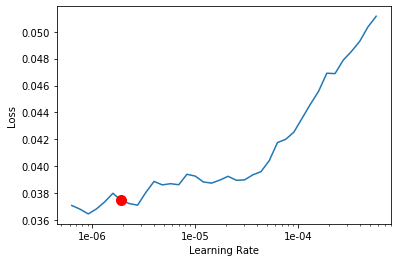

In [ ]:
learner.recorder.plot(skip_end=7,suggestion=True)

Due to randomness, there can be little differences in the learning rate. Based on a few runs on my computer, I've chosen 2e-4 for the starting point of my kaggle submission. 

#### Train with progressive unfreezing

Because the code to progressively unfreeze and train the model is very repetitive, I have made it into a loop. I unfreeze only the first 5 layer groups because I run out of memory after that. The learning rates and number of epochs are mostly arbitrary.

In [ ]:
unfreeze_layers = [-1,-2,-3]
learning_rates = [3e-4, 1e-5, 5e-6]
epochs = [3,4,8]

In [ ]:
unfreeze_layers = [-1,-3,-5,-7,-9,-11,-14]
learning_rates = [2e-4, 5e-5, 5e-5, 5e-5, 1e-5,1e-5,1e-6]
epochs = [2, 2, 2, 2, 3, 3,10]
learner.loss_func

FlattenedLoss of MSELoss()

In [ ]:
def model_unfreezing_and_training():
    for layer in range(0,len(unfreeze_layers)):
        print(layer)
        if layer == num_groups-1: 
            learner.unfreeze()     
        else: 
            learner.freeze_to(unfreeze_layers[layer])
        
        print('freezing to:',unfreeze_layers[layer],' - ',epochs[layer],'epochs')
        learner.fit_one_cycle(epochs[layer], 
                              max_lr=slice(learning_rates[layer]*0.95**num_groups, learning_rates[layer]),
                              moms=(0.8, 0.9))
        learner.save((MODEL_ROOT/('cycle_'+str(layer)+'.pth')).resolve())

0
freezing to: -1  -  2 epochs


epoch,train_loss,valid_loss,avg_spearman,time
0,0.068146,0.054086,0.210837,01:09
1,0.058184,0.052203,0.230248,01:10


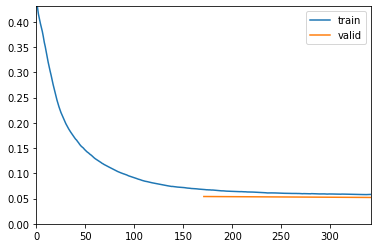

1
freezing to: -3  -  2 epochs


epoch,train_loss,valid_loss,avg_spearman,time
0,0.052859,0.044402,0.316103,01:28
1,0.046160,0.041495,0.338157,01:27


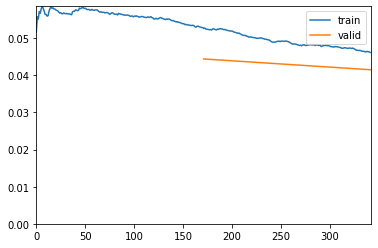

2
freezing to: -5  -  2 epochs


epoch,train_loss,valid_loss,avg_spearman,time
0,0.048203,0.040790,0.341431,01:46
1,0.043365,0.039034,0.357296,01:46


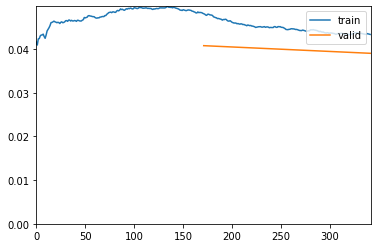

3
freezing to: -7  -  2 epochs


epoch,train_loss,valid_loss,avg_spearman,time
0,0.045803,0.040874,0.346298,02:05
1,0.040011,0.038321,0.364832,02:05


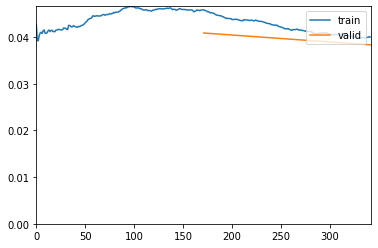

4
freezing to: -9  -  3 epochs


epoch,train_loss,valid_loss,avg_spearman,time
0,0.038645,0.038076,0.364102,02:24
1,0.037672,0.038431,0.365527,02:23
2,0.035523,0.038321,0.364133,02:23


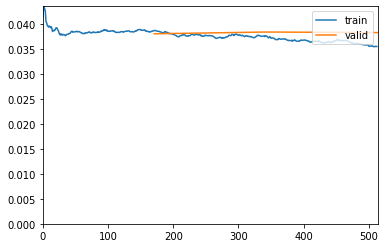

5
freezing to: -11  -  3 epochs


epoch,train_loss,valid_loss,avg_spearman,time


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 14.73 GiB total capacity; 14.13 GiB already allocated; 73.88 MiB free; 69.86 MiB cached)

In [ ]:
model_unfreezing_and_training()

In [ ]:
num_groups
0.95**num_groups

0.48767497911552954

In [ ]:
learning_rates[2]

1e-05

In [ ]:
slice(learning_rates[2]*0.95**num_groups, learning_rates[2])

slice(4.876749791155296e-06, 1e-05, None)

epoch,train_loss,valid_loss,avg_spearman,time
0,0.037606,0.038284,0.368466,03:21
1,0.036678,0.038514,0.369255,03:31
2,0.036379,0.038311,0.366529,03:31


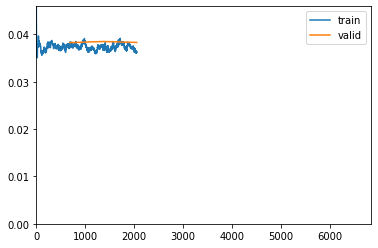

KeyboardInterrupt: 

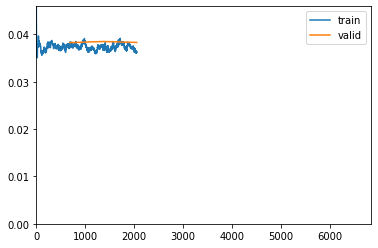

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(10, 
                              max_lr=1e-06)

In [ ]:
learner.export(MODEL_ROOT.resolve()/"export.pkl")

In [ ]:
learner=load_learner(MODEL_ROOT.resolve())

In [ ]:
learner.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
learner.export(MODEL_ROOT.resolve()/"export.pkl")

PicklingError: Can't pickle <function <lambda> at 0x7fec0cdca0e0>: attribute lookup <lambda> on __main__ failed

In [ ]:
learn=load_learner((MODEL_ROOT/('cycle_'+str(6)+'.pth')).resolve())

AttributeError: 'method-wrapper' object has no attribute '__code__'

In [ ]:
learner.unfreeze()
learner.fit_one_cycle(5, 
                              max_lr=slice(learning_rates[2]*0.95**num_groups, learning_rates[2]),
                              moms=(0.8, 0.9))

# Predictions and Submission

Now that the model is trained, we can generate our predictions from the test dataset. As [noted in other tutorials](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) the function ``get_preds`` does not return elements in order by default. Therefore, we will have to resort the test elements into their correct order.

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
test_preds,test_preds.shape

In [ ]:
sample_submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')
sample_submission[labels] = test_preds
sample_submission.to_csv("submission.csv", index=False)

We check the order

In [ ]:
test.head()

In [ ]:
sample_submission.head()

Thanks for looking through this kernel! I hope that it helps you understand transformers, and how to integrate Huggingface with fastai. 

Check out the original for some other cool architectures:
[Fastai with HuggingFace 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)

## References
* [Fastai with HuggingFace 🤗Transformers (BERT, RoBERTa, XLNet, XLM, DistilBERT)](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)
* Hugging Face, Transformers GitHub (Nov 2019), [https://github.com/huggingface/transformers](https://github.com/huggingface/transformers)
* Fast.ai, Fastai documentation (Nov 2019), [https://docs.fast.ai/text.html](https://docs.fast.ai/text.html)
* Jeremy Howard & Sebastian Ruder, Universal Language Model Fine-tuning for Text Classification (May 2018), [https://arxiv.org/abs/1801.06146](https://arxiv.org/abs/1801.06146)
* Keita Kurita's article : [A Tutorial to Fine-Tuning BERT with Fast AI](https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/) (May 2019)
* Dev Sharma's article : [Using RoBERTa with Fastai for NLP](https://medium.com/analytics-vidhya/using-roberta-with-fastai-for-nlp-7ed3fed21f6c) (Sep 2019)